In [1]:
!pip install Bio
!pip install pysam

import pysam
import numpy as np
import pandas as pd
from Bio import SeqIO
from scipy.stats import binom
from collections import Counter
from itertools import permutations
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.0/281.0 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 11.2 MB/s eta 0:00:00 0:00:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 60.9 MB/s eta 0:00:00:00:0100:01


In [6]:
working_dir = "/kaggle/working/"
data_dir = "/kaggle/input/squidrna/"

gfl_bam = pysam.AlignmentFile(data_dir + "gfl.bam", "rb")

In [7]:
ids = []
sequences = []
orf_starts = []
orf_ends = []

with open(working_dir + "outfile.txt", "w") as out:

    for seq in SeqIO.parse(data_dir + "pealeii.fasta", "fasta"):
    
        out.write(seq.id + "\n")
    
        ids.append(seq.id)
        sequences.append(seq.seq)
    
        desc = seq.description.split("\t")
        orf_starts.append(desc[2])
        orf_ends.append(desc[4])

df = pd.DataFrame({"id": ids, "start": orf_starts, "end": orf_ends, "seq": sequences})
df["start"] = df["start"].astype(int)
df["end"] = df["end"].astype(int)

In [19]:
i = 0
letters = "ACTG"
error_rate = 1e-3
min_base_quality = 30
alpha = 0.05

transcript_name = "comp141540_c0_seq3"
orf_start = df["start"][i]
orf_end = df["end"][i]
orf_range = orf_end - orf_start

In [20]:
def count_matches(positions: dict, letter: str):
    
    read_range = range(max(positions.keys()) + 1)
    
    matches = [positions.get(i, "").count(letter) for i in read_range]
    matches = list(map(lambda x: x / sum(matches), matches))
    
    return matches

In [90]:
gene_pileup = gfl_bam.pileup(
    start=orf_start,
    stop=orf_end,
    min_base_quality=min_base_quality
)

position_dict = {}
pair_counter = Counter({"".join(pair): 0 for pair in permutations(letters, 2)})
ref_seq, var_seq = "", ""
pval_list = []
n = 0

with open(working_dir + "modifications.txt", "w") as results:
    
    results.write("Position\tCoverage\tA\tC\tT\tG\tVar\tTotal\tPadj\n")
        
    for column in gene_pileup:
        
        if n == 10000:
            break
            
        n += 1
        
        base_counter = Counter({base: 0 for base in letters})
        
        for read in column.pileups:
            if not read.is_del and not read.is_refskip: 
                
                read_pos = read.query_position
                base = read.alignment.query_sequence[read_pos]

                base_counter.update(base)
                position_dict[read_pos] = position_dict.get(read_pos, "") + base

        ref, var = base_counter.most_common(2)
        pval = binom.cdf(ref[1], ref[1] + var[1], 1 - error_rate)
        
        ref_seq += ref[0]
        var_seq += var[0]
        pval_list.append(pval)

        if pval < alpha / orf_range:
            
            pair_counter.update({ref[0] + var[0]: 1})
                        
            matches = count_matches(position_dict, ref[0])
            mismatches = count_matches(position_dict, var[0])

            results.write(f"{column.pos}\t{column.n}\t")
            results.write(f"{base_counter['A']}\t{base_counter['C']}\t")
            results.write(f"{base_counter['T']}\t{base_counter['G']}\t")
            results.write(f"{var[1]}\t{ref[1] + var[1]}\t{pval:.2g}\n")

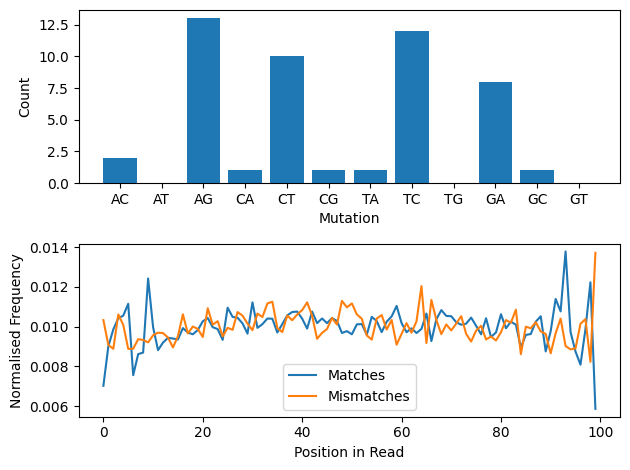

In [22]:
fig, axes = plt.subplots(2)

axes[0].bar(pair_counter.keys(), pair_counter.values())
axes[0].set_xlabel("Mutation")
axes[0].set_ylabel("Count")

axes[1].plot(matches, label="Matches")
axes[1].plot(mismatches, label="Mismatches")

axes[1].set_xlabel("Position in Read")
axes[1].set_ylabel("Normalised Frequency")
axes[1].legend(loc="lower center")

plt.tight_layout()

In [157]:
significant_arr = np.array(pval_list) < alpha / orf_range
aa_counter = Counter()

with open(working_dir + "aminoacids.txt", "w") as results:
    
    results.write("Position\tCodonPosition\tRefSeq\tVarSeq\tRefAA\tVarAA\n")
    
    for pos in range(len(ref_seq)):
        if significant_arr[pos]:

            codon_idx = pos % 3
            results.write(f"{pos}\t{codon_idx}\t")

            subseq = ref_seq[pos - codon_idx:pos + 3 - codon_idx]
            ref_aa = translate(subseq)
            results.write(f"{subseq}\t{ref_aa}\t")

            subseq = list(subseq)
            subseq[codon_idx] = var_seq[pos]
            subseq = "".join(subseq)

            var_aa = translate(subseq)
            results.write(f"{subseq}\t{var_aa}\n")
            
            if ref_aa == var_aa:
                aa_counter.update({"synonymous": 1})
            else:
                aa_counter.update({ref_aa + var_aa: 1})

<Axes: ylabel='Modification'>

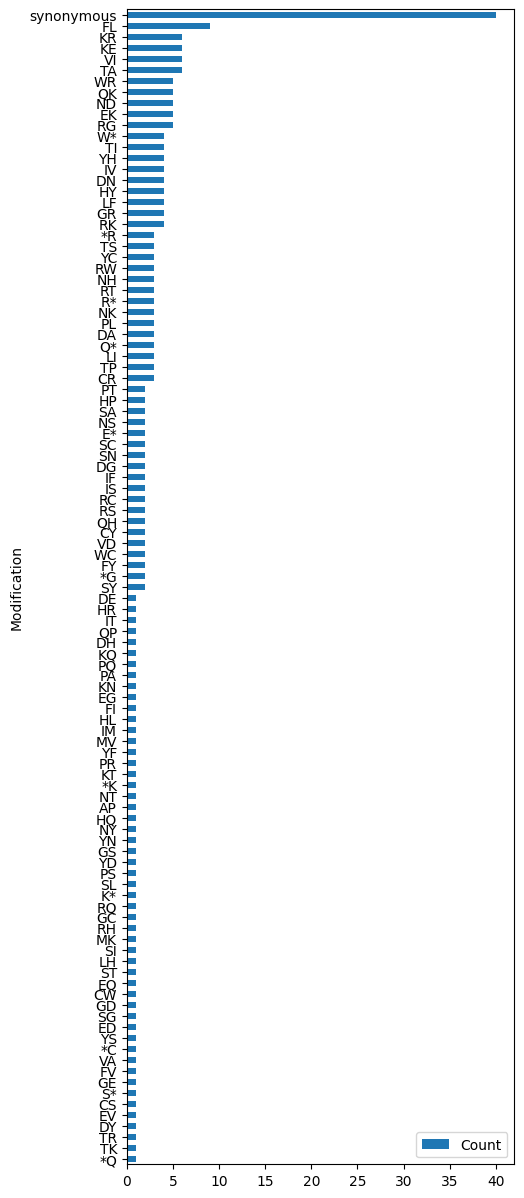

In [156]:
aa_df = pd.DataFrame.from_dict(aa_counter, orient="index").reset_index()
aa_df.columns = ["Modification", "Count"]
aa_df.sort_values("Count",inplace=True)

aa_df.plot(kind="barh", y="Count", x="Modification", figsize=(5, 15))